In [1]:
import numpy as np
import pandas as pd
# install pandas_ta - https://github.com/twopirllc/pandas-ta
import pandas_ta as ta

import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import mlflow

from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from scipy.signal import periodogram

from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

# Pipelines
from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer

# Metrics
from sklearn.metrics import classification_report, roc_auc_score

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier

# Algorithmic Trading Bot

## 0. Step-by-step guide to building an algorithmic trading bot for Bitcoin

Here's a step-by-step guide to building an algorithmic trading bot for Bitcoin, utilizing machine learning to identify buy and sell signals.

### Step 0.1: Data Collection

First, gather historical Bitcoin price data, which will be used for model training. Ideally, this data should include:

1. **Price Data**: Open, close, high, and low prices over specific time intervals (e.g., daily, hourly).
2. **Trading Volumes**: The amount of Bitcoin traded during the respective time intervals.
3. **Technical Indicators**: Calculate indicators like RSI, MACD, Moving Averages, etc., commonly used for trading decisions.

You can use APIs from **Binance**, **Coinbase Pro**, or **Yahoo Finance** to download this data.

### Step 0.2: Data Preparation

1. **Data Cleaning**:
   - Remove missing or anomalous values.
   - Convert time series data if necessary to ensure consistent time intervals.

2. **Calculate Technical Indicators**:
   - Add columns with calculated values for RSI, MACD, Moving Averages, and other relevant indicators.

3. **Define Target Variable**:
   - Define the target, such as whether the price will increase or decrease. You can create a binary variable (1 for "buy," 0 for "sell") based on price changes over a certain period (e.g., if the price increases by more than 1% in the next period).

### Step 0.3: Building the Predictive Model

1. **Model Selection**:
   - Use supervised learning models like **Random Forest**, **XGBoost**, or **SVM** to classify moments as "buy" or "sell."

2. **Training the Model**:
   - Split the data into training and testing sets.
   - Train the model on the training data and tune hyperparameters for optimal performance.

3. **Model Evaluation**:
   - Use metrics like **accuracy**, **F1 score**, **Precision**, and **Recall** to assess how well the model predicts "buy" and "sell" signals.

### Step 0.4: Strategy Simulation (Backtesting)

Before deploying the bot in a live environment, backtest it to assess its performance on historical data.

1. **Use the Test Dataset**: Evaluate how the bot would perform if buy and sell decisions had been made based on historical data.
2. **Evaluate the Strategy**: Calculate key metrics like:
   - **Return**: Compare achieved profit relative to a baseline (e.g., buy-and-hold).
   - **Maximum Drawdown**: Assess the largest losses during consecutive failed trades.
   - **Risk/Reward Ratio**.

### Step 0.5: Deployment in a Live Environment

1. **Choose a Trading Platform**:
   - Connect the bot to a trading API from exchanges like **Binance** or **Coinbase Pro**, which support live order execution.

2. **Build the Bot’s Core Logic**:
   - At each predefined interval (e.g., hourly), the bot should pull current data, calculate new indicators, and predict whether to buy or sell.
   - If the prediction is "buy," the bot sends a buy order; if "sell," a sell order.

3. **Risk Management Parameters**:
   - Define stop-loss and take-profit limits.
   - Set a maximum amount of funds the bot can use per trade, ensuring it does not take excessive risks.

### Step 0.6: Monitoring and Optimization

1. **Monitor Real-Time Bot Performance**:
   - Collect statistics on real trades to assess the model’s success in live conditions.

2. **Model Adjustment**:
   - Regularly update the data and retrain the model to accommodate new market conditions.
   - Test new indicators or models if optimization is required.

This strategy can be expanded by including other factors, such as sentiment analysis or blockchain transaction data.

## 1. Step 1: Data Collection

First, gather historical Bitcoin price data, which will be used for model training. Ideally, this data should include:

1. **Price Data**: Open, close, high, and low prices over specific time intervals (e.g., daily, hourly).
2. **Trading Volumes**: The amount of Bitcoin traded during the respective time intervals.
3. **Technical Indicators**: Calculate indicators like RSI, MACD, Moving Averages, etc., commonly used for trading decisions.

You can use APIs from **Binance**, **Coinbase Pro**, or **Yahoo Finance** to download this data.

### 1.1. Gather historical Bitcoin price data

**Price Data**: Gathered the open, close, high, and low prices over specific time intervals (every minute)

**Trading Volumes**: The amount of Bitcoin traded during the respective time intervals.

**TODO**: what ist Unit of the volume ????

In [2]:
btc_price_data_1_year = pd.read_csv("data/bitcoin_historical_data_1_year.csv")
btc_price_data_1_year

,timestamp,open,high,low,close,volume,date,time
0,2023-11-01 00:00:00,34618.86,34676.51,34656.38,34667.88,48.953000,2023-11-01,00:00:00
1,2023-11-01 00:01:00,34642.54,34687.53,34673.30,34642.82,16.178075,2023-11-01,00:01:00
2,2023-11-01 00:02:00,34637.97,34656.82,34642.53,34656.56,8.753120,2023-11-01,00:02:00
3,2023-11-01 00:03:00,34617.22,34656.56,34656.56,34629.34,11.308610,2023-11-01,00:03:00
4,2023-11-01 00:04:00,34597.99,34630.42,34629.41,34622.27,8.583808,2023-11-01,00:04:00
...,...,...,...,...,...,...,...,...
528627,2024-10-31 23:56:00,70238.76,70248.97,70248.97,70238.76,1.189134,2024-10-31,23:56:00
528628,2024-10-31 23:57:00,70218.00,70250.00,70238.77,70233.24,4.767082,2024-10-31,23:57:00
528629,2024-10-31 23:58:00,70193.97,70242.25,70232.55,70207.78,9.589688,2024-10-31,23:58:00
528630,2024-10-31 23:59:00,70175.16,70207.79,70207.79,70197.83,7.112237,2024-10-31,23:59:00


In [105]:
features = btc_price_data_1_year.drop(columns=['target'])  # Features
target = btc_price_data_1_year['target']  # Target variable

In [106]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# features = ['trend', 'seasonal', 'residual', 'trend_rolling_mean', 'residual_rolling_std']
btc_price_data_1_year[features.columns] = scaler.fit_transform(btc_price_data_1_year[features.columns])

C:\Users\valch\AppData\Local\Temp\ipykernel_11800\643422252.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc_price_data_1_year[features.columns] = scaler.fit_transform(btc_price_data_1_year[features.columns])


In [107]:
btc_price_data_1_year

,open,high,low,close,volume,year,month,day,weekday,hour,...,lag_18,lag_30,lag_32,lag_39,lag_43,lag_46,lag_47,lag_56,future_return,target
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-11-01 02:47:00,0.010234,0.008947,0.009445,0.009353,0.001272,0.0,0.909091,0.0,0.333333,0.086957,...,0.009449,0.009723,0.009639,0.009576,0.009342,0.008678,0.009330,0.010273,0.512694,0
2023-11-01 02:48:00,0.010049,0.008879,0.009377,0.009164,0.001838,0.0,0.909091,0.0,0.333333,0.086957,...,0.009698,0.009407,0.009479,0.009249,0.009269,0.008963,0.008678,0.009995,0.515964,0
2023-11-01 02:49:00,0.009853,0.008708,0.009187,0.009139,0.000940,0.0,0.909091,0.0,0.333333,0.086957,...,0.009646,0.009206,0.009723,0.009529,0.009211,0.008793,0.008963,0.010069,0.510694,0
2023-11-01 02:50:00,0.009664,0.008666,0.009163,0.008850,0.001305,0.0,0.909091,0.0,0.333333,0.086957,...,0.009728,0.009342,0.009407,0.009739,0.009535,0.009342,0.008793,0.009774,0.520649,0
2023-11-01 02:51:00,0.009740,0.008637,0.008873,0.009061,0.001413,0.0,0.909091,0.0,0.333333,0.086957,...,0.009985,0.009071,0.009206,0.009660,0.009576,0.009269,0.009342,0.009838,0.513765,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-31 23:55:00,0.912476,0.910065,0.910178,0.910166,0.001378,1.0,0.818182,1.0,0.500000,1.000000,...,0.917014,0.915272,0.915637,0.915728,0.913121,0.912191,0.912600,0.913545,0.513945,0
2024-10-31 23:56:00,0.912218,0.909662,0.910177,0.909909,0.001021,1.0,0.818182,1.0,0.500000,1.000000,...,0.915691,0.915430,0.915677,0.915093,0.913190,0.911898,0.912191,0.915509,0.515098,0
2024-10-31 23:57:00,0.911695,0.909688,0.909920,0.909770,0.004095,1.0,0.818182,1.0,0.500000,1.000000,...,0.914546,0.915587,0.915272,0.915421,0.913973,0.911875,0.911898,0.915737,0.510194,0


In [3]:
btc_price_data_1_year.describe().T

,count,mean,std,min,25%,50%,75%,max
open,528632.0,57052.764723,11061.821828,34079.460000,44083.780000,61015.800000,66127.655000,73718.320000
high,528632.0,57100.379874,11072.504219,34133.680000,44119.545000,61066.475000,66178.047500,73835.570000
low,528632.0,57076.624894,11067.091134,34113.930000,44103.265000,61041.025000,66153.502500,73815.030000
close,528632.0,57076.858348,11067.114019,34114.860000,44103.380000,61041.340000,66154.337500,73815.430000
volume,528632.0,8.915933,17.137792,0.001083,1.730652,4.020989,9.541108,1163.832604


In [4]:
btc_price_data_1_year.dtypes

timestamp     object
open         float64
high         float64
low          float64
close        float64
volume       float64
date          object
time          object
dtype: object

In [5]:
btc_price_data_1_year.isnull().sum()

timestamp    0
open         0
high         0
low          0
close        0
volume       0
date         0
time         0
dtype: int64

## 2. Step 2: Data Preparation

1. **Data Cleaning**:
   - Remove missing or anomalous values.
   - Convert time series data if necessary to ensure consistent time intervals.

2. **Calculate Technical Indicators**:
   - Add columns with calculated values for RSI, MACD, Moving Averages, and other relevant indicators.

3. **Define Target Variable**:
   - Define the target, such as whether the price will increase or decrease. You can create a binary variable (1 for "buy," 0 for "sell") based on price changes over a certain period (e.g., if the price increases by more than 1% in the next period).

### 2.1. Data Tidying and Cleaning

Convert the `timestamp` column from *object* type to *datetime64* type.

In [6]:
btc_price_data_1_year.timestamp = pd.to_datetime(btc_price_data_1_year.timestamp)

`date` and `time` columns are not needed. We will drop them.

In [7]:
btc_price_data_1_year = btc_price_data_1_year.drop(columns = ["date", "time"])

In [8]:
btc_price_data_1_year.dtypes

timestamp    datetime64[ns]
open                float64
high                float64
low                 float64
close               float64
volume              float64
dtype: object

### 2.2. Set 'timestamp' as index

In [9]:
btc_price_data_1_year.set_index('timestamp', inplace=True, drop = True)

In [10]:
# Ensure the data is sorted by time
btc_price_data_1_year = btc_price_data_1_year.sort_index()

Extract various components of the datetime, such as the year, month, day, hour, and day of the week. This can help the model capture seasonality and trends.

In [11]:
btc_price_data_1_year['year'] = btc_price_data_1_year.index.year
btc_price_data_1_year['month'] = btc_price_data_1_year.index.month
btc_price_data_1_year['day'] = btc_price_data_1_year.index.day
btc_price_data_1_year['weekday'] = btc_price_data_1_year.index.weekday  # Monday=0, Sunday=6
btc_price_data_1_year['hour'] = btc_price_data_1_year.index.hour

For time-based features like hour of day, day of the week, and month, we can use cyclical encoding. This ensures that values like 23:00 and 00:00 are considered "close" to each other, rather than being far apart numerically.

In [12]:
# Extract hour and weekday
btc_price_data_1_year['hour_sin'] = np.sin(2 * np.pi * btc_price_data_1_year.index.hour / 24)  # Hour sin encoding
btc_price_data_1_year['hour_cos'] = np.cos(2 * np.pi * btc_price_data_1_year.index.hour / 24)  # Hour cos encoding
btc_price_data_1_year['weekday_sin'] = np.sin(2 * np.pi * btc_price_data_1_year.index.weekday / 7)  # Weekday sin encoding
btc_price_data_1_year['weekday_cos'] = np.cos(2 * np.pi * btc_price_data_1_year.index.weekday / 7)  # Weekday cos encoding

In [13]:
btc_price_data_1_year.columns

Index(['open', 'high', 'low', 'close', 'volume', 'year', 'month', 'day',
       'weekday', 'hour', 'hour_sin', 'hour_cos', 'weekday_sin',
       'weekday_cos'],
      dtype='object')

In [14]:
btc_price_data_1_year.dtypes

open           float64
high           float64
low            float64
close          float64
volume         float64
year             int32
month            int32
day              int32
weekday          int32
hour             int32
hour_sin       float64
hour_cos       float64
weekday_sin    float64
weekday_cos    float64
dtype: object

### 2.3. Calculate Technical Indicators

Calculate the values and add new columns with calculated values for **RSI**, **MACD**, **Moving Averages** and other relevant indicators.

#### 2.3.1. Relative Strength Index (RSI)

**RSI** is a momentum oscillator that measures the speed and change of recent price movements. It is used to identify overbought or oversold conditions in a stock's price, generally over a 14-day period.

- **Formula**: The RSI is calculated as:
  
  $$\text{RSI} = 100 - \frac{100}{1 + RS}$$
  
  where $RS$ (Relative Strength) is the ratio of **average gains** to **average losses** over the lookback period (e.g., 14 days).

- **Interpretation**:
  - **Overbought Condition**: When RSI is above 70, the asset is often considered overbought, suggesting a potential for a pullback.
  - **Oversold Condition**: When RSI is below 30, the asset is considered oversold, suggesting a potential for a rebound.

- **Calculation**:
  - Calculate the **change** in price from one day to the next.
  - Separate the changes into **gains** (positive changes) and **losses** (negative changes).
  - Compute the **average gain** and **average loss** over the 14-day period.
  - Calculate \( RS \) as the ratio of average gain to average loss.
  - Use the RSI formula to convert \( RS \) into an index between 0 and 100.

In [15]:
def calculate_rsi(data, window=14):
    """
    RSI is a momentum oscillator that measures the speed and change of price movements, typically over a 14-period interval.
    Assuming 'data' is a DataFrame with a 'close' price column

    Parameters
    ----------
    data:   a DataFrame with the time series data. A column with the name 'close' must be present in the DataFrame! 
            This column is used to calculate the 'RSI' value.
    window: the time period that is taken into account when calculating the 'RSI'
    """
    delta = data['close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    data['RSI'] = rsi
    
    return data

In [16]:
# Calculate RSI
btc_price_data_1_year = calculate_rsi(btc_price_data_1_year)

#### 2.3.2. Moving Average Convergence Divergence (MACD)

**MACD** is a trend-following momentum indicator that shows the relationship between two moving averages of an asset’s price.

- **Formula**:
  - **MACD Line**: $\text{MACD} = \text{EMA}_{\text{short}} - \text{EMA}_{\text{long}}$
  - **Signal Line**: A **9-day EMA** of the MACD line.
  - **MACD Histogram**: The difference between the MACD line and the Signal Line.

  Here, EMA stands for Exponential Moving Average, which gives more weight to recent prices.

- **Common Parameters**:
  - **Short EMA**: Often set to a 12-day EMA.
  - **Long EMA**: Often set to a 26-day EMA.
  - **Signal Line EMA**: Often set to a 9-day EMA of the MACD line.

- **Interpretation**:
  - **MACD Line Crosses Above Signal Line**: This is a bullish signal, indicating a potential buy.
  - **MACD Line Crosses Below Signal Line**: This is a bearish signal, indicating a potential sell.
  - **MACD Divergence**: If the price and MACD are moving in opposite directions, it may signal a reversal.
  - **Histogram**: The MACD histogram shows the distance between the MACD line and the Signal Line. When the histogram grows larger, it indicates a strengthening trend in that direction.

- **Application**:
  - The MACD helps traders see changes in momentum, trend direction, and possible reversal points by analyzing the difference between the short and long EMAs.

In [17]:
def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    """
    Moving Average Convergence Divergence (MACD) is calculated using two exponential moving averages (EMA):
    the 12-day EMA and the 26-day EMA, with a 9-day EMA as the signal line.
    """
    data['EMA12'] = data['close'].ewm(span=short_window, adjust=False).mean()
    data['EMA26'] = data['close'].ewm(span=long_window, adjust=False).mean()
    
    # MACD Line
    data['MACD'] = data['EMA12'] - data['EMA26']
    
    # Signal Line
    data['Signal_Line'] = data['MACD'].ewm(span=signal_window, adjust=False).mean()
    
    return data

In [18]:
# Calculate MACD (Moving Average Convergence Divergence)
btc_price_data_1_year = calculate_macd(btc_price_data_1_year)

#### 2.3.3. Moving Averages (SMA and EMA)

Moving averages smooth out price data to help identify trends over specific time frames. They are often used to see the underlying trend of an asset’s price and are among the most widely used technical indicators.

##### 2.2.3.1. Simple Moving Average (SMA)

- **Definition**: The **SMA** is the average of the closing prices over a specific period. For example, a 10-day SMA is the average closing price over the last 10 days.
  
- **Formula**:
  $$\text{SMA} = \frac{\sum_{i=1}^{N} \text{Price}_i}{N}$$
  where $N$ is the period (e.g., 10 days).

- **Interpretation**:
  - **Trend Identification**: When prices are above the SMA, it suggests an upward trend; when below, it suggests a downward trend.
  - **Crossovers**: When a short-term SMA crosses above a long-term SMA (e.g., 10-day SMA crosses above the 50-day SMA), it generates a bullish signal. The reverse crossover indicates a bearish signal.

##### 2.2.3.2. Exponential Moving Average (EMA)

- **Definition**: The **EMA** is a weighted moving average that gives more importance to recent prices, making it more responsive to new information than the SMA.
  
- **Formula**:
  - EMA uses a multiplier:
    $$\text{EMA}_\text{current} = \left(\frac{2}{N+1}\right) \times (\text{Price}_\text{current} - \text{EMA}_\text{previous}) + \text{EMA}_\text{previous}$$
    where $N$ is the number of periods.

- **Interpretation**:
  - **More Sensitive to Price Changes**: Because the EMA responds more quickly to recent prices, it is useful in identifying potential reversals and shorter-term trends.

In [19]:
def calculate_moving_averages(data, sma_window=20, ema_window=20):
    """
    Simple Moving Average (SMA) is the average price over a specified number of periods, 
    while Exponential Moving Average (EMA) gives more weight to recent prices.
    """
    # Simple Moving Average
    data['SMA'] = data['close'].rolling(window=sma_window).mean()
    
    # Exponential Moving Average
    data['EMA'] = data['close'].ewm(span=ema_window, adjust=False).mean()
    
    return data

In [20]:
# Calculate moving averages
btc_price_data_1_year = calculate_moving_averages(btc_price_data_1_year)

### 2.4. Feature Engineering

#### 1. STL 

#### **TODO: we don't need the STL !!!**

Good for visualisations, but it's performance it not so good

In [21]:
STL(btc_price_data_1_year.close, period = 24).config

{'period': 24,
 'seasonal': 7,
 'seasonal_deg': 1,
 'seasonal_jump': 1,
 'trend': 47,
 'trend_deg': 1,
 'trend_jump': 1,
 'low_pass': 25,
 'low_pass_deg': 1,
 'low_pass_jump': 1,
 'robust': False}

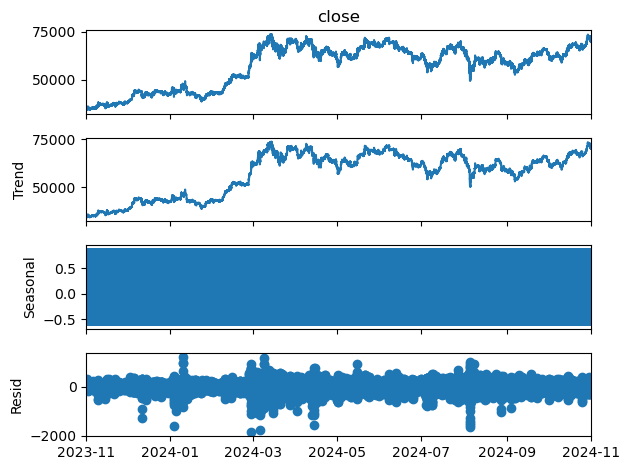

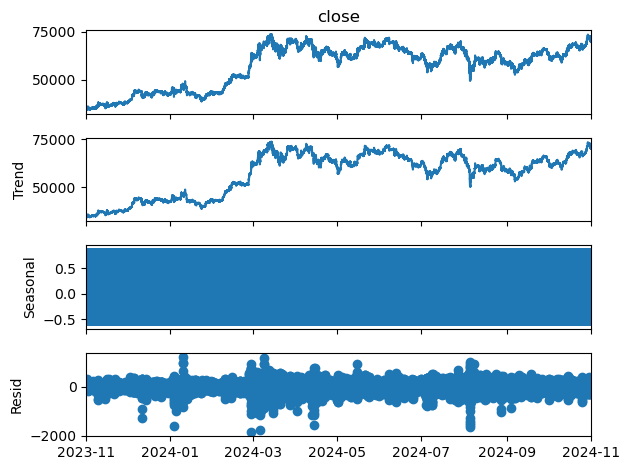

In [22]:
seasonal_decompose(btc_price_data_1_year.close, period = 24).plot()

In [23]:
seasonal_decompose(btc_price_data_1_year.close, period = 24).trend.head(20)

timestamp
2023-11-01 00:00:00             NaN
2023-11-01 00:01:00             NaN
2023-11-01 00:02:00             NaN
2023-11-01 00:03:00             NaN
2023-11-01 00:04:00             NaN
2023-11-01 00:05:00             NaN
2023-11-01 00:06:00             NaN
2023-11-01 00:07:00             NaN
2023-11-01 00:08:00             NaN
2023-11-01 00:09:00             NaN
2023-11-01 00:10:00             NaN
2023-11-01 00:11:00             NaN
2023-11-01 00:12:00    34618.809792
2023-11-01 00:13:00    34614.828125
2023-11-01 00:14:00    34610.411250
2023-11-01 00:15:00    34606.173542
2023-11-01 00:16:00    34603.065833
2023-11-01 00:17:00    34600.824792
2023-11-01 00:18:00    34598.620417
2023-11-01 00:19:00    34595.091667
Name: trend, dtype: float64

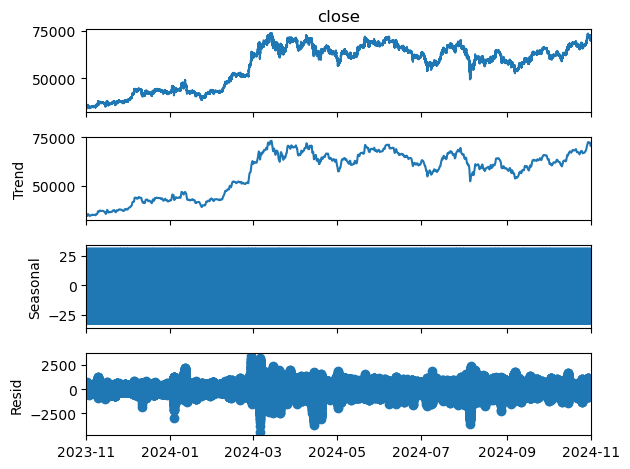

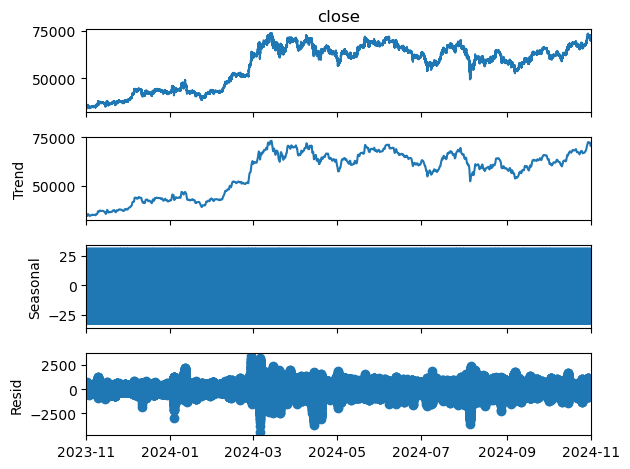

In [24]:
# 24h * 30 Days
seasonal_decompose(btc_price_data_1_year.close, period = 24 * 30).plot()

In [25]:
seasonal_decompose(btc_price_data_1_year.close, period = 24 * 30).trend.head(20)

timestamp
2023-11-01 00:00:00   NaN
2023-11-01 00:01:00   NaN
2023-11-01 00:02:00   NaN
2023-11-01 00:03:00   NaN
2023-11-01 00:04:00   NaN
2023-11-01 00:05:00   NaN
2023-11-01 00:06:00   NaN
2023-11-01 00:07:00   NaN
2023-11-01 00:08:00   NaN
2023-11-01 00:09:00   NaN
2023-11-01 00:10:00   NaN
2023-11-01 00:11:00   NaN
2023-11-01 00:12:00   NaN
2023-11-01 00:13:00   NaN
2023-11-01 00:14:00   NaN
2023-11-01 00:15:00   NaN
2023-11-01 00:16:00   NaN
2023-11-01 00:17:00   NaN
2023-11-01 00:18:00   NaN
2023-11-01 00:19:00   NaN
Name: trend, dtype: float64

In [26]:
btc_price_data_1_year.shape

(528632, 21)

In [27]:
# Subset for decomposition (daily prices in this example)
# btc_price_data_1_year_resample_hour = btc_price_data_1_year.resample('D').mean()  # Resample to daily data if needed
# btc_price_data_1_year_resample_hour = btc_price_data_1_year.resample('h').mean()  # Resample to daily data if needed

In [28]:
btc_price_data_1_year.index

DatetimeIndex(['2023-11-01 00:00:00', '2023-11-01 00:01:00',
               '2023-11-01 00:02:00', '2023-11-01 00:03:00',
               '2023-11-01 00:04:00', '2023-11-01 00:05:00',
               '2023-11-01 00:06:00', '2023-11-01 00:07:00',
               '2023-11-01 00:08:00', '2023-11-01 00:09:00',
               ...
               '2024-10-31 23:51:00', '2024-10-31 23:52:00',
               '2024-10-31 23:53:00', '2024-10-31 23:54:00',
               '2024-10-31 23:55:00', '2024-10-31 23:56:00',
               '2024-10-31 23:57:00', '2024-10-31 23:58:00',
               '2024-10-31 23:59:00', '2024-11-01 00:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=528632, freq=None)

In [29]:
# Apply STL decomposition
stl = STL(btc_price_data_1_year['close'], seasonal=7, robust=True, period = 24)  # 7-day weekly seasonality (adjust as needed)
result = stl.fit()

In [30]:
result

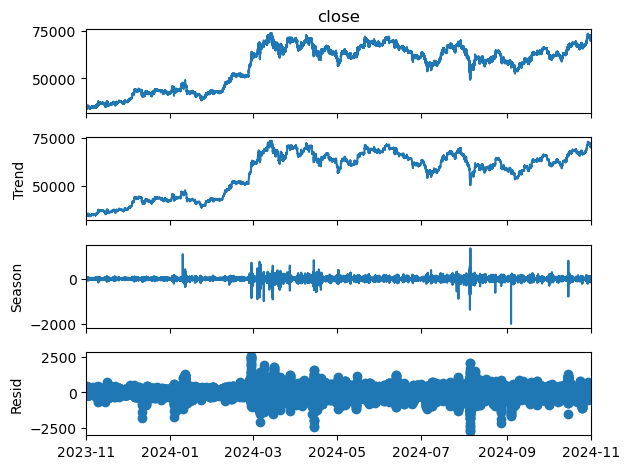

In [31]:
# Extract components
btc_price_data_1_year['trend'] = result.trend
btc_price_data_1_year['seasonal'] = result.seasonal
btc_price_data_1_year['residual'] = result.resid

# Plot the decomposition (optional)
result.plot()
plt.show()

In [32]:
# Feature Engineering
# Lagged Features
btc_price_data_1_year['trend_lag1'] = btc_price_data_1_year['trend'].shift(1)
btc_price_data_1_year['residual_lag1'] = btc_price_data_1_year['residual'].shift(1)

# Rolling Statistics
# Days
btc_price_data_1_year['trend_rolling_mean_day'] = btc_price_data_1_year['trend'].rolling(window = 24).mean()
btc_price_data_1_year['residual_rolling_std_day'] = btc_price_data_1_year['residual'].rolling(window = 24).std()

# Weeks
btc_price_data_1_year['trend_rolling_mean_week'] = btc_price_data_1_year['trend'].rolling(window = 24 * 7).mean()
btc_price_data_1_year['residual_rolling_std_week'] = btc_price_data_1_year['residual'].rolling(window= 24 * 7).std()

## TODO: do we need this ????
# Monts
# btc_price_data_1_year['trend_rolling_mean_7'] = btc_price_data_1_year['trend'].rolling(window= 30 * 24 * 7).mean()
# btc_price_data_1_year['residual_rolling_std_7'] = btc_price_data_1_year['residual'].rolling(window= 30 *  24 * 7).std()


In [33]:
btc_price_data_1_year.columns

Index(['open', 'high', 'low', 'close', 'volume', 'year', 'month', 'day',
       'weekday', 'hour', 'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos',
       'RSI', 'EMA12', 'EMA26', 'MACD', 'Signal_Line', 'SMA', 'EMA', 'trend',
       'seasonal', 'residual', 'trend_lag1', 'residual_lag1',
       'trend_rolling_mean_day', 'residual_rolling_std_day',
       'trend_rolling_mean_week', 'residual_rolling_std_week'],
      dtype='object')

#### 2. Fourier Analysis

#### **TODO: Do we need the Fourier Analysis? We have to interpret the results/chart**

In [34]:
frequencies, power = periodogram(btc_price_data_1_year.close, fs = len(btc_price_data_1_year))
# frequencies, power = periodogram(x, fs=1.0, window='boxcar', nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=-1)

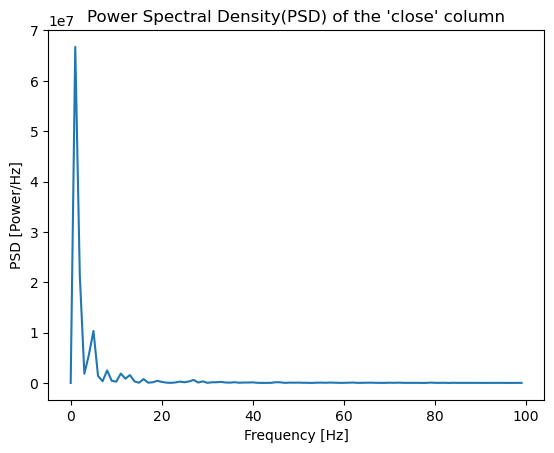

In [35]:
# plt.plot(frequencies, power)
# plt.plot(1/frequencies[1:10000], power[1:10000])
plt.plot(frequencies[:100], power[:100])
# plt.semilogy(frequencies, power)

plt.xlabel("Frequency [Hz]")
plt.ylabel("PSD [Power/Hz]")
plt.title("Power Spectral Density(PSD) of the 'close' column")
plt.show()

#### 3. Autocorrelation

Autocorrelation in time series refers to the correlation of a time series with a lagged version of itself. It measures how past values of the series influence current values. Understanding autocorrelation can help identify patterns, trends, and periodicity in time-series data.

##### Why Autocorrelation Matters
- **Pattern Detection**: Helps identify repeating patterns or seasonality.
- **Modeling Assumptions**: Many models (like ARIMA) assume specific autocorrelation structures.
- **Feature Engineering**: Insights from autocorrelation can guide the creation of lag-based features for machine learning models.

##### Types of Autocorrelation
1. **Positive Autocorrelation**: High values follow high values, and low values follow low values.
2. **Negative Autocorrelation**: High values follow low values, and vice versa.
3. **No Autocorrelation**: Values are independent of each other.

##### How to Measure Autocorrelation
The **autocorrelation function (ACF)** and the **partial autocorrelation function (PACF)** are two common tools:

###### 1. **Autocorrelation Function (ACF)**
- Measures the correlation between the time series and its lagged values.
- Useful for identifying the overall pattern of dependence at different lags.

###### 2. **Partial Autocorrelation Function (PACF)**
- Measures the correlation between the time series and its lagged values after removing the influence of shorter lags.
- Useful for determining the direct relationship between a value and a specific lag.


Set the count of the **lags** that will be considered during the Autocorrelation anylysis:

In [36]:
lags = 80

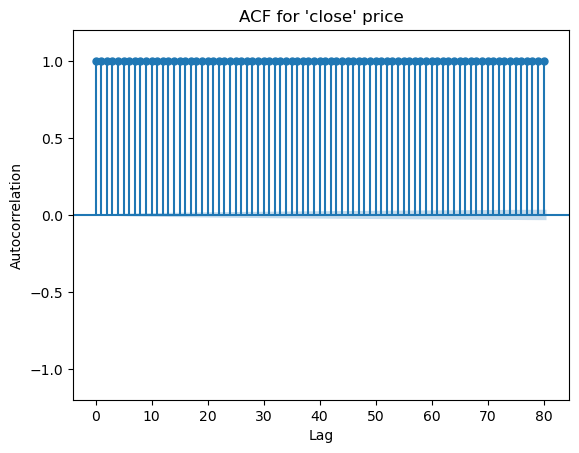

In [37]:
plot_acf(btc_price_data_1_year.close, lags = lags)
plt.ylim(-1.2, 1.2)

plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('ACF for \'close\' price')
plt.show()

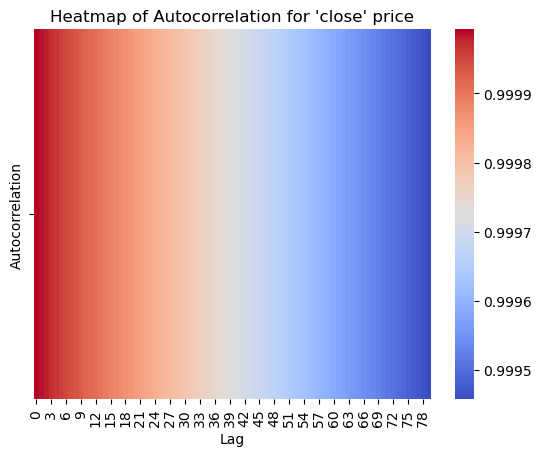

In [38]:
autocorr = [btc_price_data_1_year['close'].autocorr(lag) for lag in range(1, lags+1)]
sns.heatmap(pd.DataFrame(autocorr, columns=["Autocorrelation"]).T, annot=False, cmap="coolwarm")
plt.xlabel('Lag')
plt.title('Heatmap of Autocorrelation for \'close\' price')
plt.show()

If the autocorrelation is very large we use partial autocorrelation.

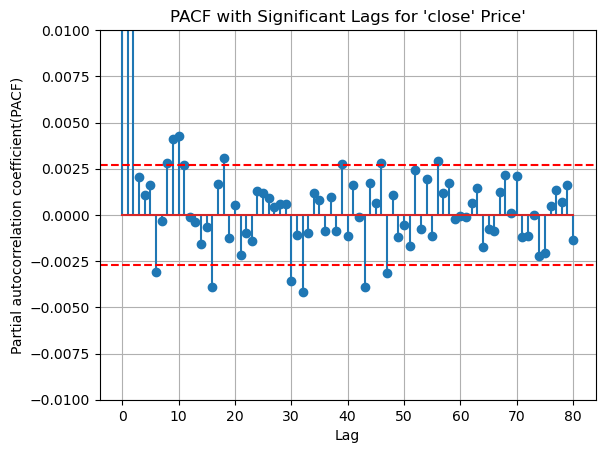

Significant Lags: [ 0  1  2  6  8  9 10 16 18 30 32 39 43 46 47 56]


In [39]:
# Calculate PACF
pacf_values = pacf(btc_price_data_1_year['close'], nlags=lags)

# Calculate the confidence interval
conf_int = 1.96 / np.sqrt(len(btc_price_data_1_year['close']))  # The 95% confidence interval

# Get significant lags (values outside the confidence interval)
significant_lags = np.where(np.abs(pacf_values) > conf_int)[0]

# Plot PACF with significant lags marked
plt.stem(pacf_values)

plt.axhline(y=conf_int, color='r', linestyle='--')
plt.axhline(y=-conf_int, color='r', linestyle='--')
plt.ylim(-0.010, 0.010)

plt.grid()

plt.xlabel('Lag')
plt.ylabel('Partial autocorrelation coefficient(PACF)')
plt.title("PACF with Significant Lags for \'close\' Price'")
plt.show()

# Print the significant lags
print("Significant Lags:", significant_lags)

**Significant lags**: Spikes that are outside the area between the two red lines are **statistically significant** at the 95% confidence level.

Correlation coefficients that are between the two red lines are **insignificant** for the model. In this area the **p-value** is too small. Correlations in this area may well be random.

In [40]:
# Remove the autocorrelation with itself (the '0'-th lag)
significant_lags = significant_lags[1:] if significant_lags[0] == 0 else significant_lags
print("Significant Lags:", significant_lags)

Significant Lags: [ 1  2  6  8  9 10 16 18 30 32 39 43 46 47 56]


In [41]:
# Create lag features (past values as features) for supervised learning
def create_lag_features(df, lags = []):
    """
    Create lag features (past values as features) for supervised learning
    """
    # Create a copy of the DataFrame
    df_copy = df.copy(deep=True)
    
    for lag in lags:
        df_copy[f'lag_{lag}'] = df_copy['close'].shift(lag)
        
    #df.dropna(inplace=True)
    return df_copy

In [42]:
btc_price_data_1_year = create_lag_features(btc_price_data_1_year, significant_lags)

In [43]:
btc_price_data_1_year.shape

(528632, 45)

In [44]:
btc_price_data_1_year.columns

Index(['open', 'high', 'low', 'close', 'volume', 'year', 'month', 'day',
       'weekday', 'hour', 'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos',
       'RSI', 'EMA12', 'EMA26', 'MACD', 'Signal_Line', 'SMA', 'EMA', 'trend',
       'seasonal', 'residual', 'trend_lag1', 'residual_lag1',
       'trend_rolling_mean_day', 'residual_rolling_std_day',
       'trend_rolling_mean_week', 'residual_rolling_std_week', 'lag_1',
       'lag_2', 'lag_6', 'lag_8', 'lag_9', 'lag_10', 'lag_16', 'lag_18',
       'lag_30', 'lag_32', 'lag_39', 'lag_43', 'lag_46', 'lag_47', 'lag_56'],
      dtype='object')

### 2.5. Calculate Target Variable

In [45]:
def create_target_variable(data, threshold = 0.01):
    """
    Computes and sets the 'target' variable from the input 'data' and 'threshold'.
    Creates a 'target' column with the computed values in the 'data' DataFrame.

    Parameters
    ----------
    data: a DataFrame with the time series data. There must be a column named 'close'! 
          This column will be used by the user to calculate the 'target' variable.
    
    threshold: threshold for the price change to classify as 'buy' or 'sell'. For instance, if you want a 1% increase to be a 'buy' signal,
               the threshold will be 0.01. Adjust this threshold as per your strategy.
    """
    # Create a copy of the DataFrame
    data_copy = data.copy(deep=True)
    
    # Compute the percentage change between the current close price and the close price in the next period.
    # This will help define whether there’s a significant increase or decrease.
    data_copy['future_return'] = ((data_copy['close'].shift(-1) - data_copy['close']) / data_copy['close']) * 100

    # Define the target as 1 (buy) if the future return is above the threshold, and 0 (sell) if it is below or equal to the threshold.
    data_copy['target'] = (data_copy['future_return'] > threshold).astype(float)

    # The last row in your dataset will have a NaN value for 'future_return' due to the shift operation. Drop this row to clean up the dataset.
    #data_copy = data_copy.dropna()

    # Check the balance of 1s and 0s in our target variable to understand how many “buy” and “sell” signals we have.
    print(data_copy['target'].value_counts())

    return data_copy

In [46]:
def create_target_variable_with_techn_indicators(data, price_threshold = 0.01):
    """
    Computes and sets the 'target' variable from the input 'data' and 'threshold'.
    Creates a 'target' column with the computed values in the 'data' DataFrame.

    Parameters
    ----------
    data: a DataFrame with the time series data. There must be a column named 'close'! 
          This column will be used by the user to calculate the 'target' variable.
    
    threshold: threshold for the price change to classify as 'buy' or 'sell'. For instance, if you want a 1% increase to be a 'buy' signal,
               the threshold will be 0.01. Adjust this threshold as per your strategy.
    """
    # Create a copy of the DataFrame
    data_copy = data.copy(deep=True)
    
    # Compute the percentage change between the current close price and the close price in the next period.
    # This will help define whether there’s a significant increase or decrease.
    data_copy['future_return'] = ((data_copy['close'].shift(-1) - data_copy['close']) / data_copy['close']) * 100
    
    # Use the technical indicators to add more conditions to the target:
    # - RSI: A Relative Strength Index (RSI) value below 30 often indicates an oversold condition, which might suggest a buying opportunity.
    # - MACD: A positive MACD value (i.e., MACD > Signal Line) can suggest an uptrend.
    # - SMA/EMA: If the current price is above the SMA or EMA, it may indicate an upward trend.
    #data_copy['buy_signal'] = (
    conditions_buy  = (
        (data_copy['future_return'] > price_threshold) &
        # (data_copy['RSI'] < 30) &   # buy signal for RSI
        (data_copy['RSI'] < 40) &    # buy signal for RSI
        ((data_copy['MACD'] > data_copy['Signal_Line']) & (data_copy['MACD'].shift(1) <= data_copy['Signal_Line'].shift(1))) & # buy signal for MACD
        ((data_copy['close'] > data_copy['SMA']) & (data_copy['close'].shift(1) <= data_copy['SMA'].shift(1))) # buy signal for SMA
    ).astype(int)

    conditions_sell  = (
        (data_copy['future_return'] < - price_threshold) &
        #(data_copy['RSI'] > 70) &    # sell signal for RSI 
        (data_copy['RSI'] > 60) &     # sell signal for RSI 
        (data_copy['MACD'] < data_copy['Signal_Line']) & (data_copy['MACD'].shift(1) >= data_copy['Signal_Line'].shift(1)) & # sell signal for MACD 
        (data_copy['close'] < data_copy['SMA']) & (data_copy['close'].shift(1) >= data_copy['SMA'].shift(1)) # sell signal for SMA 
    ).astype(int)

    # Define the 'target' as 1 (buy), 0(do nothing) and -1(sell).
    # Initialize the 'target' column with default value
    data_copy['target'] = 0 # 'do nothing' signal
    
    # Fill the 'target' with the 'buy_signal' and 'sell_signal' conditions 
    data_copy.loc[(conditions_buy == 1) & (conditions_sell == 0), 'target'] = 1 # 'buy' signal
    data_copy.loc[(conditions_sell == 1) & (conditions_buy == 0), 'target'] = -1 # 'sell' signal

    # Generate signals
    # data['signal'] = np.where(data['SMA_short'] > data['SMA_long'], 1, 0)
    # data['signal'] = data['signal'].diff()  # 1 = Buy, -1 = Sell

    # The last row in your dataset will have a NaN value for 'future_return' due to the shift operation. Drop this row to clean up the dataset.
    # data_copy = data_copy.dropna()

    # Print the balance of 1s, 0s and -1s in our 'target' variable to understand how many 'buy' and 'sell' signals we have.
    print(data_copy['target'].value_counts())

    return data_copy

In [47]:
def create_target_variable_with_techn_indicators_hourly(data, price_threshold = 0.01):
    """
    Computes and sets the 'target' variable from the input 'data' and 'threshold'.
    Creates a 'target' column with the computed values in the 'data' DataFrame.

    Parameters
    ----------
    data: a DataFrame with the time series data. There must be a column named 'close'! 
          This column will be used by the user to calculate the 'target' variable.
    
    threshold: threshold for the price change to classify as 'buy' or 'sell'. For instance, if you want a 1% increase to be a 'buy' signal,
               the threshold will be 0.01. Adjust this threshold as per your strategy.
    """
    # Create a copy of the DataFrame
    data_copy = data.copy(deep=True)
    
    # Compute the percentage change between the current close price and the close price in the next period.
    # This will help define whether there’s a significant increase or decrease.
    data_copy['future_return'] = ((data_copy['close'].shift(-1) - data_copy['close']) / data_copy['close']) * 100
    
    # Use the technical indicators to add more conditions to the target:
    # - RSI: A Relative Strength Index (RSI) value below 30 often indicates an oversold condition, which might suggest a buying opportunity.
    # - MACD: A positive MACD value (i.e., MACD > Signal Line) can suggest an uptrend.
    # - SMA/EMA: If the current price is above the SMA or EMA, it may indicate an upward trend.
    #data_copy['buy_signal'] = (
    conditions_buy  = (
        (data_copy['future_return'] > price_threshold) &
        #(data_copy['RSI'] < 30) &   # buy signal for RSI
        (data_copy['RSI'] < 40) &    # buy signal for RSI
        ((data_copy['MACD'] > data_copy['Signal_Line']) & (data_copy['MACD'].shift(1) <= data_copy['Signal_Line'].shift(1))) #& # buy signal for MACD
        # ((data_copy['close'] > data_copy['SMA']) & (data_copy['close'].shift(1) <= data_copy['SMA'].shift(1))) # buy signal for SMA
    ).astype(int)

    conditions_sell  = (
        (data_copy['future_return'] < - price_threshold) &
        #(data_copy['RSI'] > 70) &    # sell signal for RSI 
        (data_copy['RSI'] > 60) &     # sell signal for RSI 
        (data_copy['MACD'] < data_copy['Signal_Line']) & (data_copy['MACD'].shift(1) >= data_copy['Signal_Line'].shift(1)) #& # sell signal for MACD 
        # (data_copy['close'] < data_copy['SMA']) & (data_copy['close'].shift(1) >= data_copy['SMA'].shift(1)) # sell signal for SMA 
    ).astype(int)

    # Define the 'target' as 1 (buy), 0(do nothing) and -1(sell).
    # Initialize the 'target' column with default value
    data_copy['target'] = 0 # 'do nothing' signal
    
    # Fill the 'target' with the 'buy_signal' and 'sell_signal' conditions 
    data_copy.loc[(conditions_buy == 1) & (conditions_sell == 0), 'target'] = 1 # 'buy' signal
    data_copy.loc[(conditions_sell == 1) & (conditions_buy == 0), 'target'] = -1 # 'sell' signal

    # Generate signals
    # data['signal'] = np.where(data['SMA_short'] > data['SMA_long'], 1, 0)
    # data['signal'] = data['signal'].diff()  # 1 = Buy, -1 = Sell

    # The last row in your dataset will have a NaN value for 'future_return' due to the shift operation. Drop this row to clean up the dataset.
    # data_copy = data_copy.dropna()

    # Print the balance of 1s, 0s and -1s in our 'target' variable to understand how many 'buy' and 'sell' signals we have.
    print(data_copy['target'].value_counts())

    return data_copy

In [48]:
# Define the threshold for the price change to classify as 'buy' or 'sell'. For instance, if we want a 1% increase to be a 'buy' signal,
# the threshold will be 0.01.
threshold = 0.01

# Compute the 'target' variable
btc_price_data_1_year = create_target_variable_with_techn_indicators_hourly(btc_price_data_1_year, threshold)

target
 0    525868
-1      1458
 1      1306
Name: count, dtype: int64


### Backtest

In [49]:
btc_price_data_1_year.columns

Index(['open', 'high', 'low', 'close', 'volume', 'year', 'month', 'day',
       'weekday', 'hour', 'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos',
       'RSI', 'EMA12', 'EMA26', 'MACD', 'Signal_Line', 'SMA', 'EMA', 'trend',
       'seasonal', 'residual', 'trend_lag1', 'residual_lag1',
       'trend_rolling_mean_day', 'residual_rolling_std_day',
       'trend_rolling_mean_week', 'residual_rolling_std_week', 'lag_1',
       'lag_2', 'lag_6', 'lag_8', 'lag_9', 'lag_10', 'lag_16', 'lag_18',
       'lag_30', 'lag_32', 'lag_39', 'lag_43', 'lag_46', 'lag_47', 'lag_56',
       'future_return', 'target'],
      dtype='object')

In [50]:
btc_price_data_1_year.shape

(528632, 47)

In [51]:
btc_price_data_1_year.target.value_counts()

target
 0    525868
-1      1458
 1      1306
Name: count, dtype: int64

count buy: 1
Buy signal balance: 1000
Buy signal position: 0.028930078892325142
--------------------------------
count sell: 2
Sell signal position: 0.028930078892325142
Sell signal balance: 996.0093849175929
--------------------------------
count buy: 3
Buy signal balance: 996.0093849175929
Buy signal position: 0.0289642438881977
--------------------------------
count sell: 4
Sell signal position: 0.0289642438881977
Sell signal balance: 1023.053299436003
--------------------------------
count buy: 5
Buy signal balance: 1023.053299436003
Buy signal position: 0.029013965098727508
--------------------------------
count sell: 6
Sell signal position: 0.029013965098727508
Sell signal balance: 1002.0660477818385
--------------------------------
count buy: 7
Buy signal balance: 1002.0660477818385
Buy signal position: 0.029132342175526158
--------------------------------
count sell: 8
Sell signal position: 0.029132342175526158
Sell signal balance: 1007.6574182155872
---------------------------

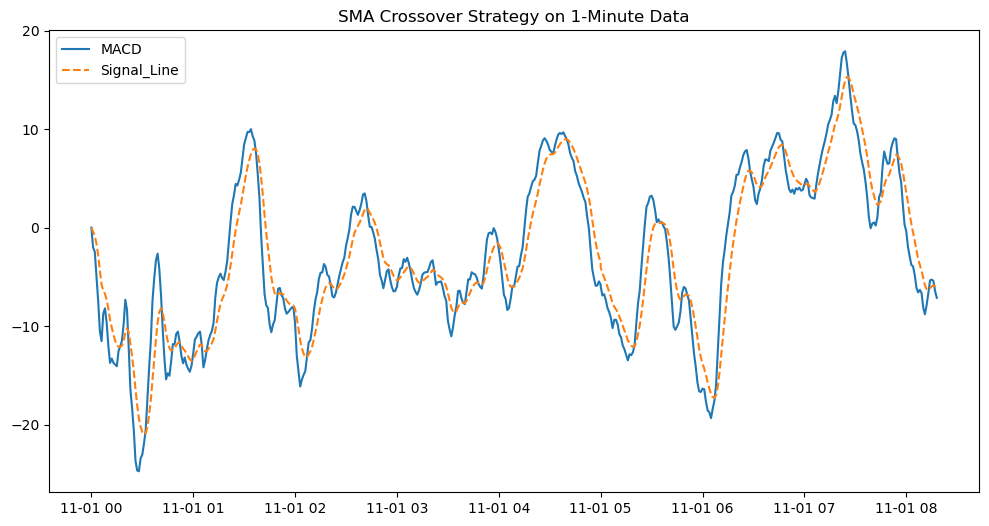

In [52]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# Load your Bitcoin dataset (assume columns: 'timestamp', 'close', 'high', 'low', 'volume')
# df = pd.read_csv('bitcoin_price.csv')
# df['timestamp'] = pd.to_datetime(df['timestamp'])
# df.set_index('timestamp', inplace=True)

df = btc_price_data_1_year

# # Resample the data to different timeframes
# def resample_data(data, timeframe='15T'):
#     return data.resample(timeframe).mean()

    # return data.resample(timeframe).agg({
    #     'close': 'last', 
    #     'high': 'max', 
    #     'low': 'min', 
    #     'volume': 'sum'
    # }).dropna()

# # Apply a simple moving average crossover strategy
# def sma_crossover_strategy(data, short_window=10, long_window=50):
#     data['SMA_short'] = data['close'].rolling(window=short_window).mean()
#     data['SMA_long'] = data['close'].rolling(window=long_window).mean()
    
#     # Generate signals
#     data['signal'] = np.where(data['SMA_short'] > data['SMA_long'], 1, 0)
#     data['signal'] = data['signal'].diff()  # 1 = Buy, -1 = Sell
#     return data

# Backtest the strategy
def backtest(data, initial_balance=1000):
    balance = initial_balance
    position = 0  # Number of Bitcoin held
    count = 0
    for i in range(1, len(data)):
        # print("target: ", data.target)
        if data['target'].iloc[i] == 1 and balance > 0:  # Buy signal
            count = count + 1
            print("count buy:", count)
            
            print("Buy signal balance:", balance)
            position = balance / data['close'].iloc[i]
            print("Buy signal position:", position)
            print("--------------------------------")
            balance = 0
        elif data['target'].iloc[i] == -1 and position > 0:  # Sell signal
            count = count + 1
            print("count sell:", count)
            
            print("Sell signal position:", position)
            balance = position * data['close'].iloc[i]
            print("Sell signal balance:", balance)
            print("--------------------------------")
            position = 0
    # Final portfolio value
    final_balance = balance + (position * data['close'].iloc[-1])
    print("final_balance after:", final_balance)
    return final_balance

# Test on multiple timeframes
timeframes = [ '1h']
# timeframes = ['1min', '5min', '15min', '1h', '4h', '1D']
results = {}

for timeframe in timeframes:
    # df_resampled = resample_data(df, timeframe)
    # df_strategy = sma_crossover_strategy(df_resampled)
    # final_balance = backtest(df_strategy)
    # print(df_resampled.shape)
    # Compute the 'target' variable
    # df_strategy = create_target_variable_with_techn_indicators(df_resampled, threshold)
    final_balance = backtest(df)
    results[timeframe] = final_balance

# Print results
for timeframe, balance in results.items():
    print(f"Final Balance with {timeframe} data: ${balance:.2f}")
    final_return = ((balance - 1000) / 1000) * 100
    print(f"Final Return with {timeframe} data: ${final_return:.2f}[%]")

# Visualize a selected timeframe (e.g., 15-minute data)
# df_strategy = sma_crossover_strategy(resample_data(df, '15T'))
# df_strategy = resample_data(df, '1h')
plt.figure(figsize=(12, 6))
# plt.plot(df_strategy['close'], label='Close Price')
plt.plot(df['MACD'][:500], label='MACD', linestyle='-')
plt.plot(df['Signal_Line'][:500], label='Signal_Line', linestyle='--')
plt.legend()
plt.title('SMA Crossover Strategy on 1-Minute Data')
plt.show()

### 2.6. Clean up the Data

In [53]:
btc_price_data_1_year.describe().T

,count,mean,std,min,25%,50%,75%,max
open,528632.0,57052.764723,11061.821828,34079.460000,44083.780000,6.101580e+04,66127.655000,73718.320000
high,528632.0,57100.379874,11072.504219,34133.680000,44119.545000,6.106648e+04,66178.047500,73835.570000
low,528632.0,57076.624894,11067.091134,34113.930000,44103.265000,6.104102e+04,66153.502500,73815.030000
close,528632.0,57076.858348,11067.114019,34114.860000,44103.380000,6.104134e+04,66154.337500,73815.430000
volume,528632.0,8.915933,17.137792,0.001083,1.730652,4.020989e+00,9.541108,1163.832604
year,528632.0,2023.833283,0.372723,2023.000000,2024.000000,2.024000e+03,2024.000000,2024.000000
month,528632.0,6.513584,3.451354,1.000000,4.000000,7.000000e+00,10.000000,12.000000
day,528632.0,15.753742,8.810303,1.000000,8.000000,1.600000e+01,23.000000,31.000000
weekday,528632.0,2.996814,1.995341,0.000000,1.000000,3.000000e+00,5.000000,6.000000
hour,528632.0,11.497507,6.921663,0.000000,5.000000,1.100000e+01,17.000000,23.000000


In [54]:
btc_price_data_1_year.dtypes

open                         float64
high                         float64
low                          float64
close                        float64
volume                       float64
year                           int32
month                          int32
day                            int32
weekday                        int32
hour                           int32
hour_sin                     float64
hour_cos                     float64
weekday_sin                  float64
weekday_cos                  float64
RSI                          float64
EMA12                        float64
EMA26                        float64
MACD                         float64
Signal_Line                  float64
SMA                          float64
EMA                          float64
trend                        float64
seasonal                     float64
residual                     float64
trend_lag1                   float64
residual_lag1                float64
trend_rolling_mean_day       float64
r

In [55]:
btc_price_data_1_year.shape

(528632, 47)

In [56]:
btc_price_data_1_year.isnull().sum()

open                           0
high                           0
low                            0
close                          0
volume                         0
year                           0
month                          0
day                            0
weekday                        0
hour                           0
hour_sin                       0
hour_cos                       0
weekday_sin                    0
weekday_cos                    0
RSI                            1
EMA12                          0
EMA26                          0
MACD                           0
Signal_Line                    0
SMA                           19
EMA                            0
trend                          0
seasonal                       0
residual                       0
trend_lag1                     1
residual_lag1                  1
trend_rolling_mean_day        23
residual_rolling_std_day      23
trend_rolling_mean_week      167
residual_rolling_std_week    167
lag_1     

There are some rows in the dataset that have a `NaN` values (`future_return`, `RSI`, `SMA` and some `lag`-columns) due to the feature engineering process. We will delete these rows to clean up the dataset.

In [57]:
btc_price_data_1_year = btc_price_data_1_year.dropna()

In [58]:
btc_price_data_1_year.shape

(528464, 47)

In [59]:
btc_price_data_1_year.isnull().sum()

open                         0
high                         0
low                          0
close                        0
volume                       0
year                         0
month                        0
day                          0
weekday                      0
hour                         0
hour_sin                     0
hour_cos                     0
weekday_sin                  0
weekday_cos                  0
RSI                          0
EMA12                        0
EMA26                        0
MACD                         0
Signal_Line                  0
SMA                          0
EMA                          0
trend                        0
seasonal                     0
residual                     0
trend_lag1                   0
residual_lag1                0
trend_rolling_mean_day       0
residual_rolling_std_day     0
trend_rolling_mean_week      0
residual_rolling_std_week    0
lag_1                        0
lag_2                        0
lag_6   

In [60]:
btc_price_data_1_year.columns

Index(['open', 'high', 'low', 'close', 'volume', 'year', 'month', 'day',
       'weekday', 'hour', 'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos',
       'RSI', 'EMA12', 'EMA26', 'MACD', 'Signal_Line', 'SMA', 'EMA', 'trend',
       'seasonal', 'residual', 'trend_lag1', 'residual_lag1',
       'trend_rolling_mean_day', 'residual_rolling_std_day',
       'trend_rolling_mean_week', 'residual_rolling_std_week', 'lag_1',
       'lag_2', 'lag_6', 'lag_8', 'lag_9', 'lag_10', 'lag_16', 'lag_18',
       'lag_30', 'lag_32', 'lag_39', 'lag_43', 'lag_46', 'lag_47', 'lag_56',
       'future_return', 'target'],
      dtype='object')

## 3. Step 3: Building the Predictive Model

1. **Model Selection**:
   - Use supervised learning models like **Random Forest**, **XGBoost**, or **SVM** to classify moments as "buy" or "sell."

2. **Training the Model**:
   - Split the data into training and testing sets.
   - Train the model on the training data and tune hyperparameters for optimal performance.

3. **Model Evaluation**:
   - Use metrics like **accuracy**, **F1 score**, **Precision**, and **Recall** to assess how well the model predicts "buy" and "sell" signals.



Here is a detailed step-by-step procedure for creating a model to predict Bitcoin trading signals using machine learning:

### 3.1. Step 1: Data Preparation

1. **Data Splitting**:
   - Use a portion of historical data as a training set and the remaining portion as a test set (e.g., 80/20 split).

2. **Creating the Target Variable**:
   - Create a target variable for the model, such as "buy" or "sell."
   - Example: Define "buy" (1) if the price is expected to rise by more than 1% within the next 24 hours, and "sell" (0) otherwise.

3. **Adding Technical Indicators**:
   - Calculate indicators like **RSI**, **MACD**, **Bollinger Bands**, **Moving Averages**, and add them as columns to the dataset. These will be used as features for training the model.

4. **Scaling the Data**:
   - For algorithms like SVM and KNN, scale feature values to a range of 0 to 1 or -1 to 1. Use `StandardScaler` or `MinMaxScaler` from `scikit-learn`.

### 3.2. Step 2: Model Selection

1. **Choosing an Algorithm**:
   - Select a model suitable for **binary classification**, such as:
     - **Random Forest**: Capable of capturing complex, nonlinear patterns in data.
     - **XGBoost**: A boosting algorithm that often achieves high accuracy by combining weak classifiers.
     - **SVM (Support Vector Machine)**: Useful when data is well-scaled and a model with good generalization ability is needed.

2. **Implementing the Model**:
   - Import the chosen model from `scikit-learn` (e.g., `RandomForestClassifier`, `XGBClassifier`, or `SVC`).
   - Set initial hyperparameters (start with default values and optimize later).

Example code:

```python
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
```

### 3.3. Step 3: Training the Model

1. **Training the Model**:
   - Train the model using the training dataset. Split the data into X (features) and y (target variable).
   
   ```python
   model.fit(X_train, y_train)
   ```

2. **Hyperparameter Optimization (Optional)**:
   - Use `GridSearchCV` or `RandomizedSearchCV` to tune hyperparameters. This can help the model achieve better results.

### 3.4. Step 4: Model Evaluation

1. **Making Predictions**:
   - Use the model to make predictions on the test dataset.

   ```python
   y_pred = model.predict(X_test)
   ```

2. **Evaluating Performance**:
   - Use metrics for binary model evaluation, such as accuracy, precision, recall, and F1-score.
   
   ```python
   from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
   
   accuracy = accuracy_score(y_test, y_pred)
   precision = precision_score(y_test, y_pred)
   recall = recall_score(y_test, y_pred)
   f1 = f1_score(y_test, y_pred)
   
   print(f'Accuracy: {accuracy:.2f}')
   print(f'Precision: {precision:.2f}')
   print(f'Recall: {recall:.2f}')
   print(f'F1 Score: {f1:.2f}')
   ```

### 3.5. Step 5: Saving the Model (Optional)

Once the model is trained and has achieved the desired accuracy, you can save it for later use with `joblib` or `pickle`.

```python
import joblib
joblib.dump(model, 'trading_model.pkl')
```

### 3.6. Step 6: Final Testing

After training, conduct additional tests with new (unseen) data to ensure the model generalizes well to new scenarios.

Afterwards, you can use this model for real-time predictions in a trading bot.

### 3.1. Step 1: Data Preparation

#### 3.1.1 **Data Splitting**

In [61]:
attributes = btc_price_data_1_year.drop(columns=['target'])  # Features
target = btc_price_data_1_year['target']  # Target variable
attributes_train, attributes_test, target_train, target_test = train_test_split(
    attributes, 
    target, 
    test_size=0.2, 
    shuffle = False 
)

In [62]:
attributes_train.shape, attributes_test.shape

((422771, 46), (105693, 46))

In [63]:
target_train.shape, target_test.shape

((422771,), (105693,))

#### TODO: Do I need validation set???

#### 3.1.2. **Scaling the Data**:
   - For algorithms like SVM and KNN, scale feature values to a range of 0 to 1 or -1 to 1. Use `StandardScaler` or `MinMaxScaler` from `scikit-learn`.

#### TODO: Do I need to **Scale the Data**???

### 3.2. Step 2: Model Selection

1. **Choosing an Algorithm**:
   - Select a model suitable for **binary classification**, such as:
     - **Random Forest**: Capable of capturing complex, nonlinear patterns in data.
     - **XGBoost**: A boosting algorithm that often achieves high accuracy by combining weak classifiers.
     - **SVM (Support Vector Machine)**: Useful when data is well-scaled and a model with good generalization ability is needed.

2. **Implementing the Model**:
   - Import the chosen model from `scikit-learn` (e.g., `RandomForestClassifier`, `XGBClassifier`, or `SVC`).
   - Set initial hyperparameters (start with default values and optimize later).

Example code:

```python
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
```

#### 3.2.1. RandomForestClassifier

In [64]:
model = RandomForestClassifier(n_estimators=10, random_state=42)

In [65]:
model.fit(attributes_train, target_train)

RandomForestClassifier(n_estimators=10, random_state=42)

In [66]:
model.estimator_

DecisionTreeClassifier()

In [67]:
model.estimators_[0]

DecisionTreeClassifier(max_features='sqrt', random_state=1608637542)

In [68]:
model.estimators_[0].tree_.max_depth

34

In [69]:
for estimator in model.estimators_:
    print(estimator.tree_.max_depth)

34
39
37
36
37
40
36
34
37
36


#### feature_importances_

In [70]:
model.feature_importances_

array([0.01812921, 0.01762328, 0.01565741, 0.01617682, 0.03977625,
       0.00104399, 0.00750565, 0.01694472, 0.00939034, 0.01527293,
       0.01624209, 0.01632201, 0.00964468, 0.00654979, 0.07114688,
       0.01523606, 0.01467923, 0.05337434, 0.05800019, 0.01576772,
       0.01670014, 0.01666444, 0.03626623, 0.03975676, 0.01519764,
       0.03092935, 0.01540959, 0.03351557, 0.01659364, 0.03426109,
       0.01569472, 0.0147915 , 0.01903653, 0.01686386, 0.01553456,
       0.01626444, 0.01683667, 0.01588723, 0.01678692, 0.01587043,
       0.01798698, 0.01623672, 0.01738048, 0.01957432, 0.01850405,
       0.05697256])

In [71]:
model.feature_importances_.sum()

1.0

In [72]:
result_feat_imp = list(zip(btc_price_data_1_year.columns, np.round(model.feature_importances_, 3)))

In [73]:
pd.DataFrame(result_feat_imp).sort_values(1, ascending = False)

,0,1
14,RSI,0.071
18,Signal_Line,0.058
45,future_return,0.057
17,MACD,0.053
23,residual,0.040
4,volume,0.040
22,seasonal,0.036
29,residual_rolling_std_week,0.034
27,residual_rolling_std_day,0.034
25,residual_lag1,0.031


#### permutation_importance

In [74]:
#permutation_importance(model, attributes_train, target_train)

In [75]:
#permutation_importance(forest, attributes_digits, targets_digits)["importances_mean"]

In [76]:
result_permut_imp = list(zip(btc_price_data_1_year.columns, np.round(permutation_importance(model, attributes_train, target_train)["importances_mean"], 8)))

In [77]:
result_permut_imp

[('open', 0.00027533),
 ('high', 0.00032594),
 ('low', 0.00022849),
 ('close', 0.00013956),
 ('volume', 0.00124465),
 ('year', 3.311e-05),
 ('month', 0.00020768),
 ('day', 0.00045746),
 ('weekday', 0.00044847),
 ('hour', 0.00054781),
 ('hour_sin', 0.0004234),
 ('hour_cos', 0.00043191),
 ('weekday_sin', 0.00028999),
 ('weekday_cos', 0.00018024),
 ('RSI', 0.00393121),
 ('EMA12', 0.00017645),
 ('EMA26', 7.664e-05),
 ('MACD', 0.00333041),
 ('Signal_Line', 0.00389194),
 ('SMA', 0.00013956),
 ('EMA', 0.00018166),
 ('trend', 0.00016084),
 ('seasonal', 0.00078671),
 ('residual', 0.00154504),
 ('trend_lag1', 7.474e-05),
 ('residual_lag1', 0.00279158),
 ('trend_rolling_mean_day', 0.00011259),
 ('residual_rolling_std_day', 0.00133642),
 ('trend_rolling_mean_week', 0.00031128),
 ('residual_rolling_std_week', 0.00160654),
 ('lag_1', 0.00019065),
 ('lag_2', 0.00015469),
 ('lag_6', 0.00034392),
 ('lag_8', 0.00037325),
 ('lag_9', 0.00025924),
 ('lag_10', 0.00028857),
 ('lag_16', 0.00026161),
 ('lag_18

In [78]:
pd.DataFrame(result_permut_imp).sort_values(1, ascending = False)

,0,1
14,RSI,0.003931
18,Signal_Line,0.003892
17,MACD,0.003330
45,future_return,0.003068
25,residual_lag1,0.002792
29,residual_rolling_std_week,0.001607
23,residual,0.001545
27,residual_rolling_std_day,0.001336
4,volume,0.001245
22,seasonal,0.000787


In [79]:
pd.DataFrame(result_feat_imp).sort_values(1, ascending = False)

,0,1
14,RSI,0.071
18,Signal_Line,0.058
45,future_return,0.057
17,MACD,0.053
23,residual,0.040
4,volume,0.040
22,seasonal,0.036
29,residual_rolling_std_week,0.034
27,residual_rolling_std_day,0.034
25,residual_lag1,0.031


In [80]:
#pd.DataFrame(result).sort_values(1, ascending = False)

### 3.3. Create a Pipeline

In [81]:
#model = RandomForestClassifier(n_estimators=10, random_state=42)

In [82]:
model_pipeline = Pipeline(
    [
        ("forestClass", RandomForestClassifier(n_estimators=200, min_samples_split= 50, random_state=42)),
        # ("scaler", MaxAbsScaler()),
        # ("svd", TruncatedSVD(n_components = 20)),
        # ("nb", SGDClassifier(loss = "hinge"))
    ]
)

In [83]:
# model_pipeline = Pipeline(
#     [
#         ("tfidf", TfidfVectorizer()),
#         ("scaler", MaxAbsScaler()),
#         ("svd", TruncatedSVD(n_components = 20)),
#         ("nb", SGDClassifier(loss = "hinge"))
#     ]
# )

In [84]:
# tuner = RandomizedSearchCV(model_pipeline, param_distributions = {
#     "tfidf__ngram_range" : [(1, 1), (1, 2)],
#     "svd__n_components" : [3, 10, 100, 150],
# }, n_iter = 5, verbose = 3)

In [85]:
# Use '.fit' only with the train data !!!
#tuner.fit(emails_train.text, labels_train)

In [86]:
# Check with train data
#print(classification_report(labels_train, tuner.predict(emails_train.text)))

In [87]:
# Check with test data
#print(classification_report(labels_test, tuner.predict(emails_test.text)))

#### MLFlow

In [88]:
experiment_name = "BTC + RandomForestClassifier"
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None: 
    mlflow.create_experiment(experiment_name)

In [89]:
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='file:///C:/Users/valch/OneDrive/Desktop/03.Machine%20Learning-September-2024/Exam/02.Exam-Project/01.Repo/Algorithmic-Trading-Bot/Notebook/mlruns/807620600499546528', creation_time=1731885149175, experiment_id='807620600499546528', last_update_time=1731885149175, lifecycle_stage='active', name='BTC + RandomForestClassifier', tags={}>

In [90]:
with mlflow.start_run(run_name = "Training dry run"):
    mlflow.log_param("train size", len(attributes_train))
    mlflow.log_param("test size", len(attributes_test))
    # mlflow.log_param("Stratification", stratify is not None)

    # model_pipeline.fit(emails_train.text, labels_train)
    model_pipeline.fit(attributes_train, target_train)
    
    # mlflow.log_param("vocab size", len(model_pipeline["tfidf"].vocabulary_))
    # mlflow.log_param("SVD n_components", model_pipeline["svd"].n_components)
    
    mlflow.log_metric("train_accuracy", model_pipeline.score(attributes_train, target_train))
    mlflow.log_metric("test_accuracy", model_pipeline.score(attributes_test, target_test))

    with open("train_report.txt",  "w") as f:
        # f.write(classification_report(labels_train, model_pipeline.predict(emails_train.text)))
        f.write(classification_report(target_train, model_pipeline.predict(attributes_train)))
    with open("test_report.txt",  "w") as f:
        # f.write(classification_report(labels_test, model_pipeline.predict(emails_test.text)))
        f.write(classification_report(target_test, model_pipeline.predict(attributes_test)))
        
    pickle.dump(model_pipeline, open("model.pkl", "wb"))

    mlflow.log_artifact("model.pkl")
    mlflow.log_artifact("train_report.txt")
    mlflow.log_artifact("test_report.txt")

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packag

In [91]:
from sklearn.metrics import precision_score

preds = model_pipeline.predict(attributes_test)

In [92]:
np.unique(preds)

array([0], dtype=int64)

In [93]:
preds = pd.Series(preds, index = attributes_test.index)

In [94]:
precision_score(target_test, preds, average='micro') 

0.9949949381699829

In [95]:
combined = pd.concat([target_test, preds], axis = 1)

In [96]:
combined

,target,0
timestamp,,
2024-08-19 19:05:00,0,0
2024-08-19 19:06:00,0,0
2024-08-19 19:07:00,0,0
2024-08-19 19:08:00,0,0
2024-08-19 19:09:00,0,0
...,...,...
2024-10-31 23:55:00,0,0
2024-10-31 23:56:00,0,0
2024-10-31 23:57:00,0,0


<Axes: xlabel='timestamp'>

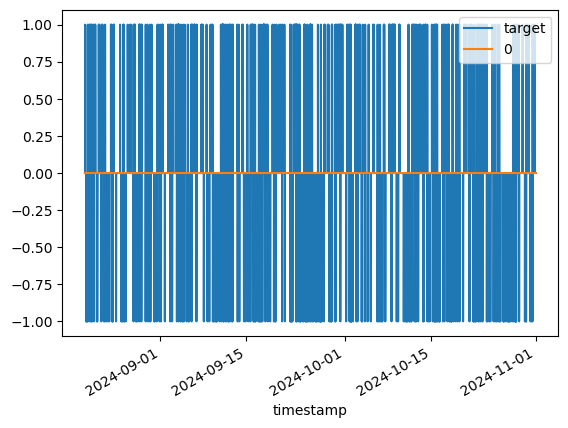

In [97]:
combined.plot()

### 3.4. Step 4: Model Evaluation

1. **Making Predictions**:
   - Use the model to make predictions on the test dataset.

In [98]:
predictions = model.predict(attributes_test)
print(predictions)

[0 0 0 ... 0 0 0]


In [99]:
print("Unique classes:", np.unique(predictions))

Unique classes: [-1  0]


2. **Evaluating Performance**:
   - Use metrics for binary model evaluation, such as accuracy, precision, recall, and F1-score.

In [100]:
# Check with train data
print(classification_report(target_train, model.predict(attributes_train)))

              precision    recall  f1-score   support

          -1       1.00      0.91      0.95      1194
           0       1.00      1.00      1.00    420537
           1       1.00      0.77      0.87      1040

    accuracy                           1.00    422771
   macro avg       1.00      0.89      0.94    422771
weighted avg       1.00      1.00      1.00    422771



In [101]:
print(classification_report(target_test, model.predict(attributes_test)))

              precision    recall  f1-score   support

          -1       0.12      0.00      0.01       264
           0       1.00      1.00      1.00    105164
           1       0.00      0.00      0.00       265

    accuracy                           0.99    105693
   macro avg       0.37      0.33      0.33    105693
weighted avg       0.99      0.99      0.99    105693



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [102]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
   
accuracy = accuracy_score(target_test, predictions)
precision = precision_score(target_test, predictions, average='macro')
recall = recall_score(target_test, predictions, average='macro')
f1 = f1_score(target_test, predictions, average='macro')
   
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Accuracy: 0.99
Precision: 0.37
Recall: 0.33
F1 Score: 0.33


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 4. Step 4: Strategy Simulation (Backtesting)

Before deploying the bot in a live environment, backtest it to assess its performance on historical data.

1. **Use the Test Dataset**: Evaluate how the bot would perform if buy and sell decisions had been made based on historical data.
2. **Evaluate the Strategy**: Calculate key metrics like:
   - **Return**: Compare achieved profit relative to a baseline (e.g., buy-and-hold).
   - **Maximum Drawdown**: Assess the largest losses during consecutive failed trades.
   - **Risk/Reward Ratio**.